# Skeletal Editing with Reaction SMARTS and RDKit Atom Substitution

This notebook shows two ways to accomplish skeletal editing reactions in the RDKit: By using Reaction SMARTS or atom editing. As my collaborator [Dr. Phyo Phyo Zin](https://www.linkedin.com/in/phyophyokyawzin/) posted in [How to Use Skeletal Editing in Drug Discovery: Key Benefits & Applications](https://drzinph.com/skeletal-editing-in-drug-discovery-applications-and-challenges/), "skeletal editing enables chemists to modify the core structure of existing molecules by swapping, deleting, inserting, or rearranging atoms ([Woo et al., 2023](https://pubmed.ncbi.nlm.nih.gov/37914946/))." For generality, Reaction SMARTS is best because it can match molecular patterns, enabling one Reaction SMARTS to apply to many reactants. For a simple reaction like pyrylium → pyridinium, we can accomplish the same thing using atom editing on an RDKit read-write molecule.

## Code foundation

This section is taken from our previous tutorial on skeletal editing. It installs the RDKit and defines functions to run and plot reactions using Reaction SMARTS.

In [1]:
%%capture
%pip install rdkit

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdqueries

from IPython.display import display

In [3]:
def run_rxn(rxn_smarts, mol):
    rxn = AllChem.ReactionFromSmarts(rxn_smarts)
    print("Reaction:")
    display(rxn)
    try:
        products = rxn.RunReactants((mol,))
    except IndexError:
        raise IndexError("Reaction failed; the starting material may not match the reaction SMARTS")
    return products

In [4]:
def plot_rxn(rxn_smarts, mol):
    try:
        products = run_rxn(rxn_smarts, mol)
    except IndexError as e:
        print(e)
        return
    print("Reactant:")
    display(mol)
    if not products:
        print("No products")
        return
    print("Distinct products:")
    product_smls = set()
    for product in products:
        product_mol = product[0]
        Chem.SanitizeMol(product_mol)
        # Get the canonical SMILES string of the product molecule
        this_sml = Chem.MolToSmiles(product_mol)
        if this_sml in product_smls:
            continue
        product_smls.add(this_sml)
        print(Chem.MolToSmiles(product_mol))
        display(product_mol)
    return product_smls

Now let's accomplish the skeletal editing reaction pyrylium → pyridinium using each method. The reaction is from Skeletal Editing: Interconversion of Arenes and Heteroarenes ([Joynson and Ball, 2023](http://doi.org/10.1002/hlca.202200182)) figure 13A and can be used in the preparation of Katritzky salts.

## Reaction SMARTS

Let's start by defining the SMARTS pattern for the starting material. It's a six-membered aromatic ring with a hetero atom, specifically oxygen. The oxygen will be replaced with a nitrogen (connected to an R group), so let's provide an atom number for the oxygen. We'll visualize the SMARTS pattern as a molecule to check that it matches the starting material:

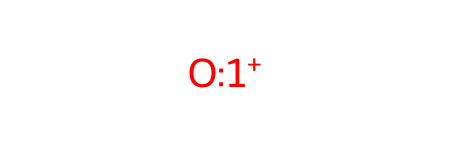

In [5]:
pyrylium_smarts = "[o+r6:1]"
pyrylium_smarts_mol = Chem.MolFromSmarts(pyrylium_smarts)
pyrylium_smarts_mol

Now we can use that reactant SMARTS and transform it to the product using [RDKit's Reaction SMARTS format](https://drzinph.com/learning-reaction-smarts-a-practical-guide-to-reaction-based-patterns/):
> [Reactants]>>[Products]

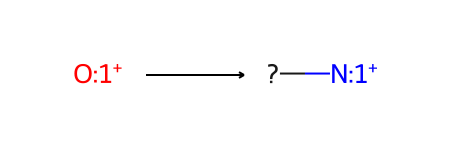

In [6]:
pyrylium_to_pyridinium = f"{pyrylium_smarts}>>[n+:1]-[R]"
pyrylium_to_pyridinium_rxn = AllChem.ReactionFromSmarts(pyrylium_to_pyridinium)
pyrylium_to_pyridinium_rxn

Let's make sure that our starting material (represented with a Kekulé structure)

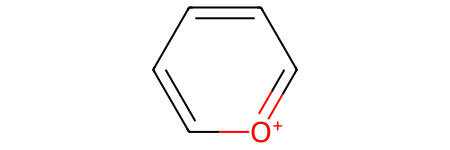

In [7]:
pyrylium_sml = "C1=[O+]C=CC=C1"
pyrylium = Chem.MolFromSmiles(pyrylium_sml)
pyrylium

matches the SMARTS pattern:

In [8]:
pyrylium.HasSubstructMatch(pyrylium_smarts_mol)

True

### Specificity of the reactant SMARTS pattern

But benzene shouldn't match the reactant SMARTS pattern because benzene lacks the oxygen in the aromatic ring:

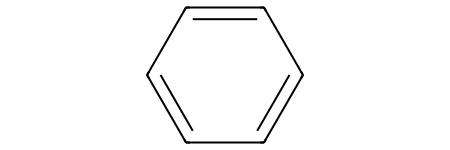

In [9]:
benzene_sml = "c1ccccc1"
benzene = Chem.MolFromSmiles(benzene_sml)
benzene

In [10]:
benzene.HasSubstructMatch(pyrylium_smarts_mol)

False

Nor should tetrahydropyran because it's not aromatic and the oxygen atom doesn't have a positive charge:

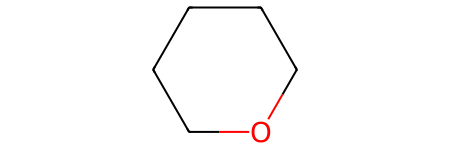

In [11]:
o_alicyclic_sml = "C1OCCCC1"
o_alicyclic = Chem.MolFromSmiles(o_alicyclic_sml)
o_alicyclic

In [12]:
o_alicyclic.HasSubstructMatch(pyrylium_smarts_mol)

False

We could have a 10-membered ring which is aromatic, but it won't match the reactant SMARTS pattern because we specified a six-membered ring:

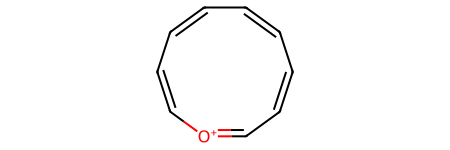

In [13]:
o_arene10_sml = "C1=CC=[O+]C=CC=CC=C1"
o_arene10 = Chem.MolFromSmiles(o_arene10_sml)
o_arene10

In [14]:
o_arene10.HasSubstructMatch(pyrylium_smarts_mol)

False

Whereas if we create a different reactant SMARTS which specifies only that the oxygen be aromatic, and not the ring size, our 10-membered ring would match:

In [15]:
pyrylium_smarts_any_ring_size = "[o+:1]"
pyrylium_smarts_any_ring_size_mol = Chem.MolFromSmarts(pyrylium_smarts_any_ring_size)
o_arene10.HasSubstructMatch(pyrylium_smarts_any_ring_size_mol)

True

This eight-membered ring with alternating double and single bonds should not match the original reactant pattern because it's anti-aromatic:

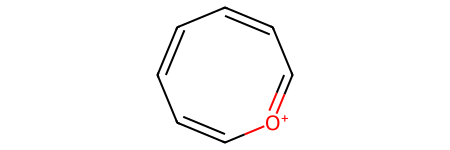

In [16]:
o_antiarene8_sml = "C1=[O+]C=CC=CC=C1"
o_antiarene8 = Chem.MolFromSmiles(o_antiarene8_sml)
o_antiarene8

In [17]:
o_antiarene8.HasSubstructMatch(pyrylium_smarts_mol)

False

### Run the Reaction SMARTS

Having established the Reaction SMARTS' specificity, let's plot the reaction:

Reaction:


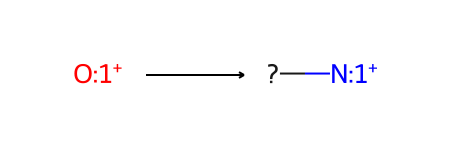

Reactant:


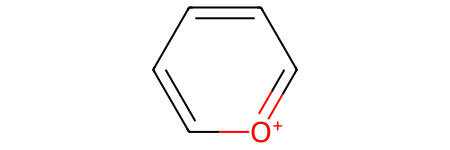

Distinct products:
*[n+]1ccccc1


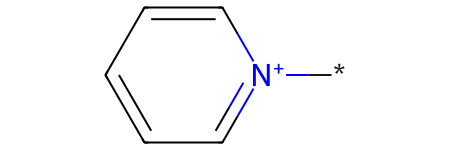

In [18]:
product_smls = plot_rxn(pyrylium_to_pyridinium, pyrylium)

To later compare to the atom-editing result, let's save the product SMILES. There's only one in the set, so we can `pop` it off.

In [19]:
product_from_rxn_smarts = product_smls.pop()
product_from_rxn_smarts

'*[n+]1ccccc1'

### Generality of the Reaction SMARTS

We can verify that our Reaction SMARTS is written in a general manner by successfully running the reaction on an ortho substituted pyrylium. Here we use the `1*` label simply as a marker; the identity of the substituted moiety might or might not affect whether this skeletal editing reaction would work in practice.

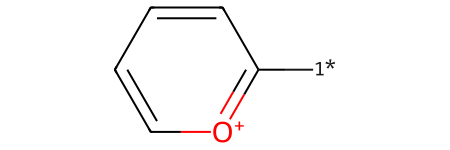

In [20]:
pyrylium_substituted_sml = "[1*]C1=[O+]C=CC=C1"
pyrylium_substituted = Chem.MolFromSmiles(pyrylium_substituted_sml)
pyrylium_substituted

Reaction:


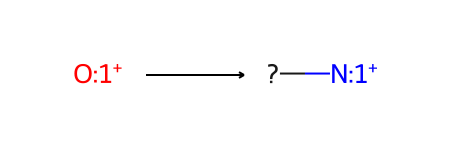

Reactant:


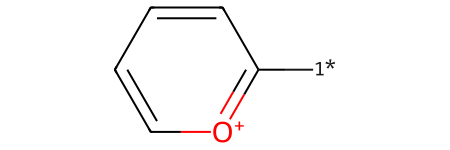

Distinct products:
*[n+]1ccccc1[1*]


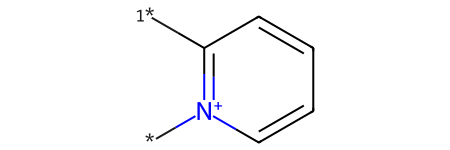

{'*[n+]1ccccc1[1*]'}

In [21]:
plot_rxn(pyrylium_to_pyridinium, pyrylium_substituted)

The ortho substitution on the arene ring is preserved, so the Reaction SMARTS worked as desired.

## RDKit atom substitution

Because this is a fairly simple atom-for-atom replacement (though with the addition of an R group on the new atom), we can accomplish the same thing by modifying the molecule. We start by creating a read-write molecule from the original (read-only) molecule and verifying that it's the same as the original:

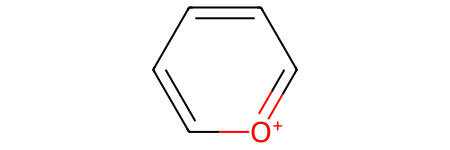

In [22]:
pyrylium_rwm = Chem.RWMol(pyrylium)
pyrylium_rwm

To programmatically identify the oxygen atom by its atomic number of 8, we create and run a query. There's only one oxygen atom, so we can simply get the first atom matching the query.

In [23]:
hetero_atom_query = rdqueries.AtomNumEqualsQueryAtom(8)
hetero_atom = pyrylium_rwm.GetAtomsMatchingQuery(hetero_atom_query)[0]
hetero_atom_idx = hetero_atom.GetIdx()
hetero_atom_idx

1

Now we'll replace the oxygen atom with a nitrogen:

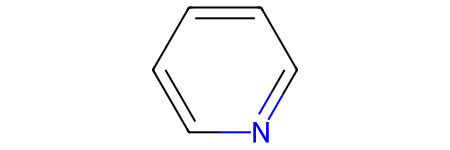

In [24]:
pyrylium_rwm.ReplaceAtom(index = hetero_atom_idx, newAtom = Chem.Atom(7))
Chem.SanitizeMol(pyrylium_rwm)
pyrylium_rwm

To add the R group to the nitrogen, we use the read-write molecule's `AddAtom` method. We start by just adding the atom `*` representing the R group. If we leave it at that, the atom is disonnected from the rest of the molecule (note the `*` floating above the rest of the molecule):

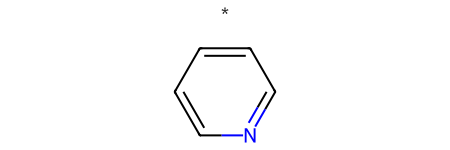

In [25]:
added_atom_idx = pyrylium_rwm.AddAtom(Chem.Atom("*"))
pyrylium_rwm

So we need to add a bond between the nitrogen and the R group. 

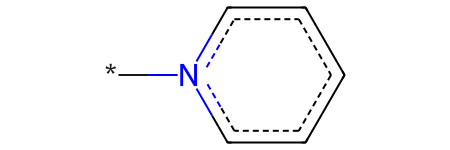

In [26]:
pyrylium_rwm.AddBond(
    beginAtomIdx = hetero_atom_idx,
    endAtomIdx = added_atom_idx,
    order = Chem.BondType.SINGLE,
    )
pyrylium_rwm

Now let's clean up the molecule by assigning the nitrogen to have no hydrogen atoms, and its charge to `+1`. First let's programmatically find the nitrogen atom. Note that its index is the same as the oxygen atom had, but we need to find the nitrogen atom (as an object) so we can adjust its properties later.

In [27]:
n_query = rdqueries.AtomNumEqualsQueryAtom(7)
n_at = pyrylium_rwm.GetAtomsMatchingQuery(n_query)[0]
n_at.SetNoImplicit(True)
n_at.SetNumExplicitHs(0)
n_at.SetFormalCharge(1)

Next we'll draw the molecule, highlighting the substituted heteroatom, the new R group, and the bond between them.

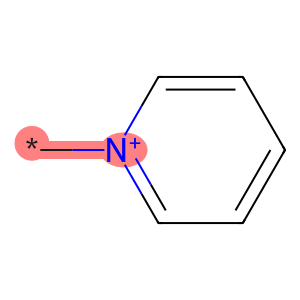

In [28]:
new_bond_idx = pyrylium_rwm.GetBondBetweenAtoms(hetero_atom_idx, added_atom_idx).GetIdx()
Draw.MolToImage(
    mol = pyrylium_rwm,
    highlightAtoms=[hetero_atom_idx, added_atom_idx],
    highlightBonds=[new_bond_idx],
    )

Finally, we'll convert the read-write molecule back to a read-only molecule, sanitize it, and display it.

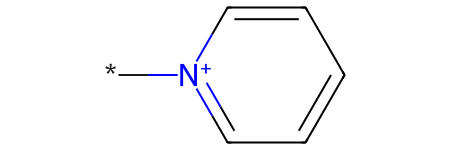

In [29]:
product = pyrylium_rwm.GetMol()
Chem.SanitizeMol(product)
product

## Equivalency of the two methods

Let's verify that the product is the same as that from the Reaction SMARTS.

In [30]:
product_from_rxn_smarts == Chem.MolToSmiles(product)

True